In [1]:
import csv
import numpy as np
import os
import operator
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tabulate import tabulate
import colorcet as cc
import sys


from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

In [29]:

REPO=True

if REPO:
    repo_url = "https://github.com/ccg-esb-lab/plasmidNoise.git"
    repo_name = "plasmidNoise"

    if not Path(repo_name).exists():
        !git clone {repo_url}

    REPO_ROOT = Path(repo_name).resolve()
    print("Repo root:", REPO_ROOT)

    codePath = REPO_ROOT / "code/"
    envPath = REPO_ROOT / "env/"
    figPath = REPO_ROOT / "figures/"
    dataPath = REPO_ROOT / 'data/pOXA48_model_params.csv'

    figPath.mkdir(parents=True, exist_ok=True)

    codePath = Path(codePath)
    print("codePath =", codePath.resolve())

    print("Files in codePath:")
    for p in codePath.iterdir():
        print("  ", p.name)

    if str(codePath) not in sys.path:
        sys.path.insert(0, str(codePath))
    import pOXA48_model




Repo root: /content/plasmidNoise
codePath = /content/plasmidNoise/code
Files in codePath:
   pOXA48_parameters.py
   __pycache__
   pOXA48_model.py


In [30]:
strains = ['C001', 'C002',  'C006',  'C011',  'C012',  'C021',  'C022',  'C031',  'C051',  'C063',  'C094',  'C107',  'C115',  'C131',  'C141',  'C201',  'C227',  'C232',  'C247',  'C261',  'C286',  'C290',  'C302',  'C309',  'C324',  'K037',  'K038',  'K087',  'K094',  'K112',  'K114',  'K125',  'K141',  'K168',  'K177',  'K200',  'K201',  'K209',  'K213',  'K216',  'K224',  'K225',  'K241',  'K248',  'K249',  'K253',  'K257',  'K275',  'K285',  'K300']
strain_names = ["PF_EC01", "PF_EC02", "PF_EC03", "PF_EC04", "PF_EC05", "PF_EC06", "PF_EC07", "PF_EC08", "PF_EC09", "PF_EC10", "PF_EC11", "PF_EC12", "PF_EC13", "PF_EC14", "PF_EC15","PF_EC16", "PF_EC17", "PF_EC18", "PF_EC19", "PF_EC20", "PF_EC21", "PF_EC22", "PF_EC23", "PF_EC24", "PF_EC25", "PF_KPN01", "PF_KPN02", "PF_KPN03", "PF_KPN04", "PF_KQ01", "PF_KPN05", "PF_KPN06", "PF_KPN07", "PF_KPN08", "PF_KPN09", "PF_KQ02", "PF_KQ03", "PF_KPN10", "PF_KPN11", "PF_KQ04", "PF_KV01", "PF_KPN12", "PF_KPN13", "PF_KPN14", "PF_KPN15", "PF_KPN16", "PF_KPN17", "PF_KPN18", "PF_KPN19", "PF_KPN20", "PF_EC01", "PF_EC02", "PF_EC03", "PF_EC04", "PF_EC05", "PF_EC06", "PF_EC07", "PF_EC08", "PF_EC09", "PF_EC10", "PF_EC11", "PF_EC12", "PF_EC13", "PF_EC14", "PF_EC15", "PF_EC16", "PF_EC17", "PF_EC18", "PF_EC19", "PF_EC20", "PF_EC21", "PF_EC22", "PF_EC23", "PF_EC24", "PF_EC25", "PF_KPN01", "PF_KPN02", "PF_KPN03", "PF_KPN04", "PF_KQ01", "PF_KPN05", "PF_KPN06", "PF_KPN07", "PF_KPN08", "PF_KPN09", "PF_KQ02", "PF_KQ03", "PF_KPN10", "PF_KPN11", "PF_KQ04", "PF_KV01", "PF_KPN12", "PF_KPN13", "PF_KPN14", "PF_KPN15", "PF_KPN16", "PF_KPN17", "PF_KPN18", "PF_KPN19", "PF_KPN20"]

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1.0 #Concentration of imiting resource
extinction_threshold=1.0 #Extinction threshold
alphas=[1e-10, 1e-12] #Antibiotic degradation rate
d=0.1 #Transfer dilution rate

A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'd': d,  # Resource concentration
    'extinction_threshold': extinction_threshold,
}
verbose=False

pOXA48_model.print_expe_params(expe_params)

Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-10 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------


In [37]:
def runMultistrainExperiment(type_experiment, model_params, strains_subset, str_E, Emax, num_Es):
    """
    Run multistrain simulations across a set of scaled environmental trajectories.

    Parameters
    ----------
    type_experiment : str
        Identifier for the experiment type.
    model_params : dict
        Model parameters passed to the simulator.
    strains_subset : list
        Strains included in the simulation.
    str_E : str
        Environment identifier used to load trajectories.
    Emax : float
        Maximum scaling applied to the environment.
    num_Es : int
        Number of environments to simulate.

    Returns
    -------
    dict
        Simulation outputs indexed by environment.
    """
    results = {}

    # Load normalized environmental trajectories
    iEs = np.arange(num_Es)
    Es_norm = pOXA48_model.load_environments(str_E, envPath, num_days, iEs)

    # Visualize environments
    for iE, E in zip(iEs, Es_norm):
        pOXA48_model.plot_environment(E, 1, f"{str_E}_{iE}")

    # Scale environments
    this_As = [Emax * E for E in Es_norm]

    print(f"Emax={Emax}")
    print(f"Strains={strains_subset}")

    # Run multistrain simulations
    Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params = \
        pOXA48_model.simulate_environments_multistrain(
            model_params, strains_subset, this_As, type_experiment
        )

    # Store outputs per environment
    for iA in range(len(this_As)):
        results[iA] = {
            "E": this_As[iA],
            "Btots": Btots[iA],
            "Bp": BpEs[iA] + BpKs[iA],
            "Bf": BfEs[iA] + BfKs[iA],
            "freqps": freqpEs[iA] + freqpKs[iA],
            "ts": ts[iA],
            "ys": ys[iA],
            "params": params[iA],
        }

    # Plot final population states
    for i, E in enumerate(this_As):
        pOXA48_model.plotPFFinalPoint(
            model_params, strains_subset, ts[i], ys[i], params[i],
            strain_names, E, Emax=2**12, save_path=""
        )

    return results


In [38]:

model_params = pOXA48_model.import_model_params("%s"%(dataPath), expe_params)

# Experiment parameters:
type_experiment='invasion'
strains_subset=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
#strains_subset=[1, 2]

str_E='blue_noise'
num_days=100
num_Es=10 #Number of different environments

#Amax_values = np.power(2.0, np.arange(4.0, 20.0, 0.2))  # Example Amax values
#Amax=2**-2
#result_data_blue_low = runMultistrainExperiment(type_experiment, model_params, strains_subset, str_E, Amax, num_Es)

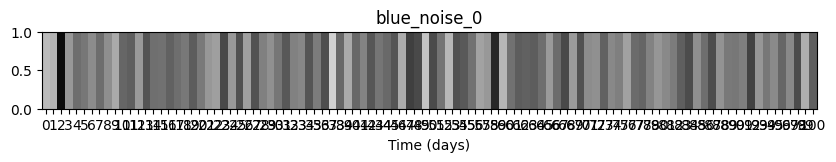

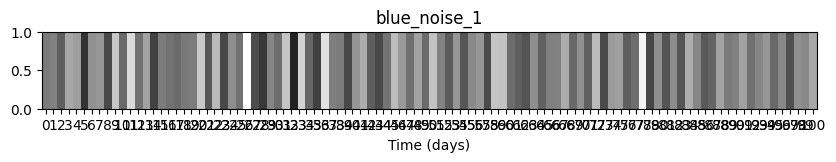

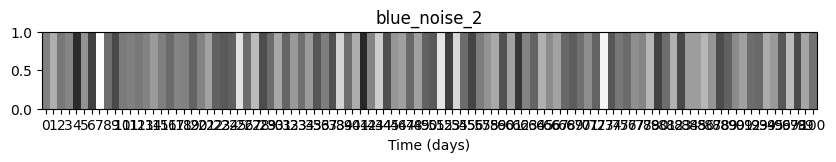

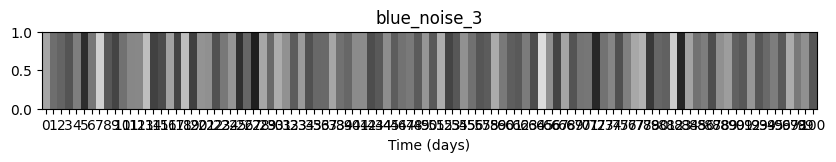

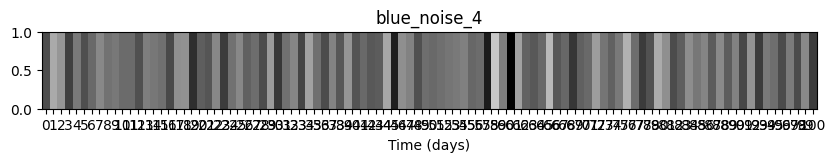

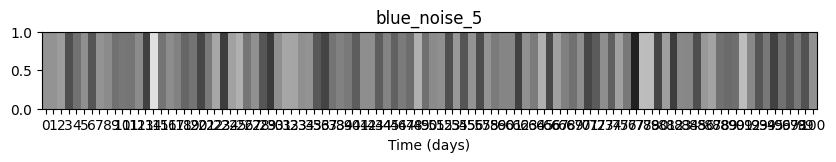

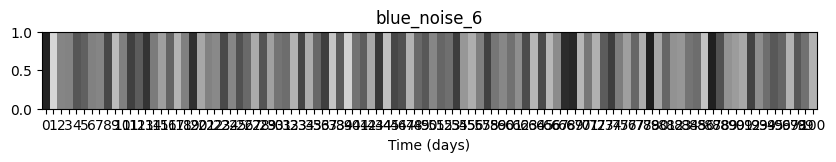

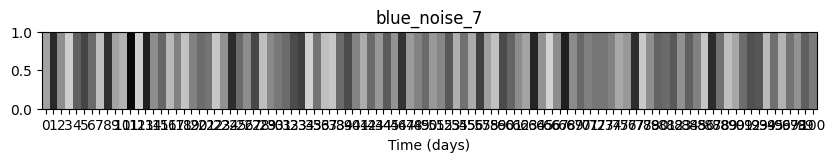

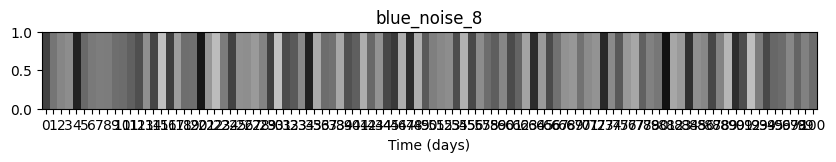

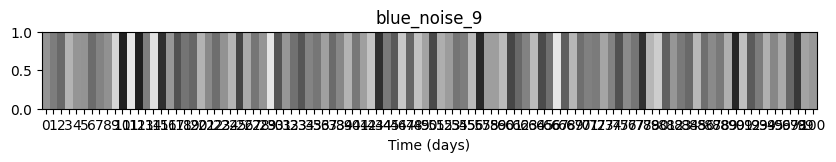

Emax=64
Strains=[1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]
..

In [ ]:
Emax = 2**6
result_data_blue_high = runMultistrainExperiment(type_experiment, model_params, strains_subset, str_E, Emax, num_Es)